In [1]:
!nvidia-smi

Mon Oct 17 09:57:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import numpy as np
import os
import cv2
import gc
import re
import copy
import itertools
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import pyplot
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob
import warnings
from IPython import display as ipd
warnings.filterwarnings("ignore")
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib.patches import Rectangle
import seaborn as sns
import random
from joblib import Parallel, delayed

In [3]:
import torch
import random
import numpy as np
import os

# 시드값 고정
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)                          # 파이썬 난수 
np.random.seed(seed)                       # 넘파이 난수
torch.manual_seed(seed)                    # 파이토치 난수 CPU 사용시
torch.cuda.manual_seed(seed)               # 파이토치 난수 GPU 사용시
torch.cuda.manual_seed_all(seed)           # 파이토치 난수 멀티 GPU 사용시
torch.backends.cudnn.deterministic = True  # 확정적 연산 사용
torch.backends.cudnn.benchmark = False     # 벤치마크 기능 해제
torch.backends.cudnn.enalbed = False       # cudnn 사용 해제

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import glob

path = '/content/drive/MyDrive/data/chest_xray/'

files = glob.glob(path + '*')
files

['/content/drive/MyDrive/data/chest_xray/chest_xray',
 '/content/drive/MyDrive/data/chest_xray/train',
 '/content/drive/MyDrive/data/chest_xray/test',
 '/content/drive/MyDrive/data/chest_xray/val']

In [6]:
normal_imgs = []
pneumonia_imgs = []

for cat in ['train/', 'val/', 'test/']:
    data_cat_path = path + cat
    normal_imgs_tmp = glob.glob(data_cat_path + 'NORMAL/*')
    pneumonia_imgs_tmp = glob.glob(data_cat_path + 'PNEUMONIA/*')

    normal_imgs.extend(normal_imgs_tmp)
    pneumonia_imgs.extend(pneumonia_imgs_tmp)    

print(len(normal_imgs), len(pneumonia_imgs))

1583 4273


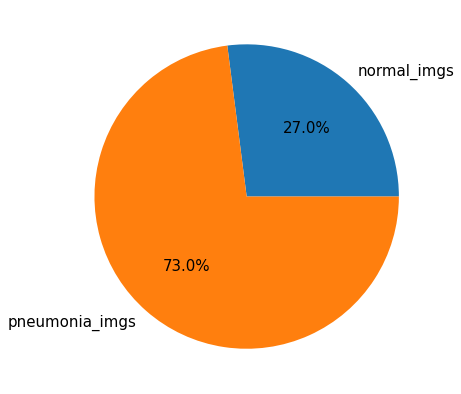

In [7]:
plt.figure(figsize=(7,7))
mpl.rc('font',size=15)
plt.pie([len(normal_imgs), len(pneumonia_imgs)],
        labels=['normal_imgs', 'pneumonia_imgs'],
        autopct='%.1f%%')
plt.show()

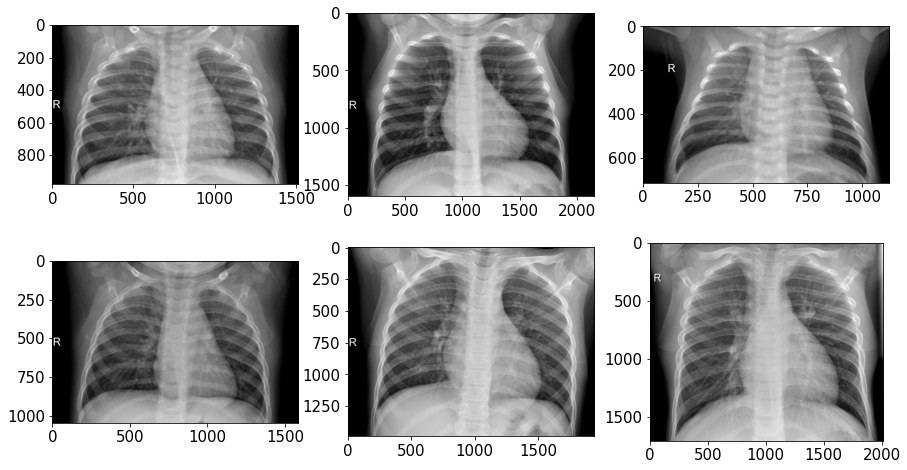

In [8]:
def show_image(img_ids, rows=2, cols=3):
    assert len(img_ids) <= rows*cols

    plt.figure(figsize=(15,8))
    grid = gridspec.GridSpec(rows,cols)

    for idx, img_id in enumerate(img_ids):
        image = cv2.imread(img_id)
        ax = plt.subplot(grid[idx])
        ax.imshow(image)
show_image(normal_imgs[-6:])

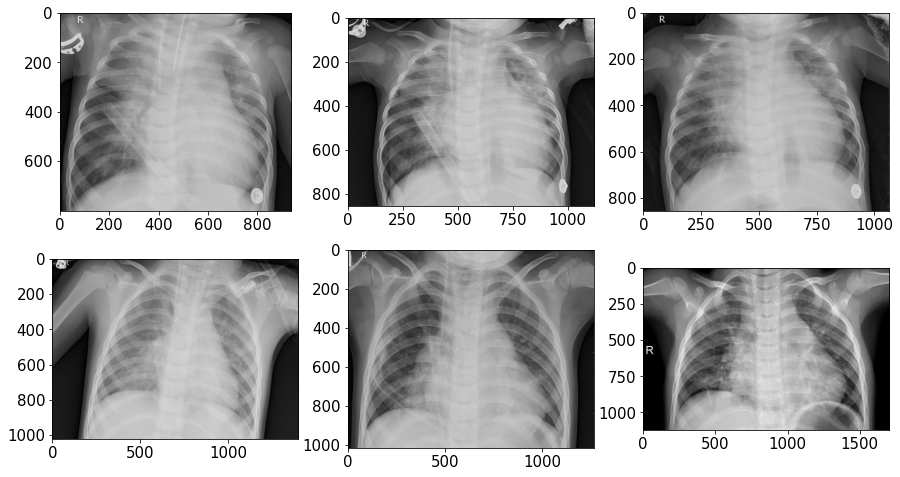

In [9]:
show_image(pneumonia_imgs[-6:])

#베이스라인 모델

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
train_path = path + 'train/'
valid_path = path + 'val/'
test_path = path + 'test/'

## 이미지 변환기 정의

In [12]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.Resize((250,250)),              # 이미지 크기 조정
    transforms.CenterCrop(180),                # 중앙 이미지 확대
    transforms.RandomVerticalFlip(0.2),        # 좌우 대칭
    transforms.RandomHorizontalFlip(0.5),      # 상하 대칭
    transforms.RandomRotation(20),             # 이미지 회전
    transforms.ToTensor(),                     # 텐서 객체로 변환
    transforms.Normalize((0.152, 0.456, 0.406),
                         (0.229, 0.224, 0.225))# 정규화
    ])

# 검증 및 테스트 데이터용 변환기
transform_test = transforms.Compose([
    transforms.Resize((250,250)),
    transforms.CenterCrop(180),                # 중앙 이미지 확대    
    transforms.ToTensor(),                     # 텐서 객체로 변환
    transforms.Normalize((0.152, 0.456, 0.406),
                         (0.229, 0.224, 0.225))# 정규화
])

## 데이터셋 및 데이터 로더

In [29]:
from torchvision.datasets import ImageFolder

# 훈련 데이터셋
datasets_train = ImageFolder(root=train_path, transform=transform_train)
# 검증 데이터셋
datasets_valid = ImageFolder(root=valid_path, transform=transform_test)

len(datasets_train), len(datasets_valid)

(5216, 16)

In [15]:
from torch.utils.data import DataLoader

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

batch_size = 8

loader_train = DataLoader(datasets_train, batch_size=batch_size,
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

loader_valid = DataLoader(datasets_valid, batch_size=batch_size,
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

In [92]:
# from torch.utils.data import Subset

# n = len(datasets_train)  # total number of examples
# n_test = 10
# datasets_train_debug = torch.utils.data.Subset(datasets_train, range(n_test))  # take first 10%

# n = len(datasets_valid)  # total number of examples
# n_test = 10
# datasets_valid_debug = torch.utils.data.Subset(datasets_valid, range(n_test))  # take first 10%

# loader_train_debug = DataLoader(datasets_train_debug, batch_size=1,
#                           shuffle=True, worker_init_fn=seed_worker,
#                           generator=g, num_workers=2)

# loader_valid_debug = DataLoader(datasets_valid_debug, batch_size=1,
#                           shuffle=False, worker_init_fn=seed_worker,
#                           generator=g, num_workers=2)

## 모델 생성

In [16]:
!pip install efficientnet-pytorch==0.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)

model = model.to(device)

Loaded pretrained weights for efficientnet-b0


In [18]:
# 모델 파라미터 개수
sum([param.numel() for param in model.parameters()])

4010110

In [19]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## 훈련

In [27]:
from sklearn.metrics import accuracy_score # 정확도 계산 함수
from sklearn.metrics import recall_score   # 재현율 계산 함수
from sklearn.metrics import f1_score       # F1 점수 계산 함수
from tqdm.notebook import tqdm             # 진행률 표시 막대

def train(model, loader_train, loader_valid, criterion, optimizer, 
          scheduler=None, epochs=10, save_file='model_state_dict.pth'):
    
    valid_loss_min = np.inf # 최소 손실값 초기화 (검증 데이터용) 

    # 총 에폭만큼 반복
    for epoch in range(epochs):
        print(f'에폭 [{epoch+1}/{epochs}] \n-----------------------------')
        
        # == [ 훈련 ] ==============================================
        model.train()        # 모델을 훈련 상태로 설정
        epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
        # '반복 횟수'만큼 반복 
        for images, labels in tqdm(loader_train):
            # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
            images = images.to(device)
            labels = labels.to(device)
            
            # 옵티마이저 내 기울기 초기화
            optimizer.zero_grad()
            # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
            outputs = model(images)
            # 손실 함수를 활용해 outputs와 labels의 손실값 계산
            loss = criterion(outputs, labels)
            # 현재 배치에서의 손실 추가 (훈련 데이터용)
            epoch_train_loss += loss.item() 
            loss.backward()       # 역전파 수행
            optimizer.step()      # 가중치 갱신
            if scheduler != None: # 스케줄러 학습률 갱신 
                scheduler.step() 

        # 훈련 데이터 손실값 출력
        print(f'\t훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
        
        # == [ 검증 ] ==============================================
        model.eval()         # 모델을 평가 상태로 설정 
        epoch_valid_loss = 0 # 에폭별 손실값 초기화 (검증 데이터용)
        preds_list = []      # 예측값 저장용 리스트 초기화
        true_list = []       # 실젯값 저장용 리스트 초기화
        
        with torch.no_grad(): # 기울기 계산 비활성화
            for images, labels in loader_valid:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_valid_loss += loss.item()
                
                # 예측값 및 실제값 
                preds = torch.max(outputs.cpu(), dim=1)[1].numpy() 
                true = labels.cpu().numpy() 
    
                preds_list.extend(preds)
                true_list.extend(true)
                
        # 정확도, 재현율, F1 점수 계산
        val_accuracy = accuracy_score(true_list, preds_list)
        val_recall = recall_score(true_list, preds_list)
        val_f1_score = f1_score(true_list, preds_list)

        # 검증 데이터 손실값 및 정확도, 재현율, F1점수 출력
        print(f'\t검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f}')
        print(f'\t정확도 : {val_accuracy:.4f} / 재현율 : {val_recall:.4f} / F1 점수 : {val_f1_score:.4f}')
        # == [ 최적 모델 가중치 찾기 ] ==============================
        # 현 에폭에서의 손실값이 최소 손실값 이하면 모델 가중치 저장 
        if epoch_valid_loss <= valid_loss_min: 
            print(f'\t### 검증 데이터 손실값 감소 ({valid_loss_min:.4f} --> {epoch_valid_loss:.4f}). 모델 저장')
            # 모델 가중치를 파일로 저장 
            torch.save(model.state_dict(), save_file) 
            valid_loss_min = epoch_valid_loss # 최소 손실값 갱신 
    return torch.load(save_file) # 저장한 모델 가중치를 불러와 반환

In [25]:
len(loader_train),len(datasets_train)/8

(652, 652.0)

In [30]:
# 모델 훈련
model_state_dict = train(model=model,
                         loader_train=loader_train, 
                         loader_valid=loader_valid,
                         criterion=criterion, 
                         optimizer=optimizer)

에폭 [1/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1897
	검증 데이터 손실값 : 2.3457
	정확도 : 0.6250 / 재현율 : 1.0000 / F1 점수 : 0.7273
	### 검증 데이터 손실값 감소 (inf --> 4.6915). 모델 저장
에폭 [2/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1894
	검증 데이터 손실값 : 4.7268
	정확도 : 0.5625 / 재현율 : 1.0000 / F1 점수 : 0.6957
에폭 [3/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1701
	검증 데이터 손실값 : 0.7775
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
	### 검증 데이터 손실값 감소 (4.6915 --> 1.5551). 모델 저장
에폭 [4/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1642
	검증 데이터 손실값 : 4.1584
	정확도 : 0.5625 / 재현율 : 1.0000 / F1 점수 : 0.6957
에폭 [5/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1664
	검증 데이터 손실값 : 4.6179
	정확도 : 0.5000 / 재현율 : 1.0000 / F1 점수 : 0.6667
에폭 [6/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1536
	검증 데이터 손실값 : 0.4868
	정확도 : 0.8750 / 재현율 : 0.8750 / F1 점수 : 0.8750
	### 검증 데이터 손실값 감소 (1.5551 --> 0.9736). 모델 저장
에폭 [7/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1571
	검증 데이터 손실값 : 0.6933
	정확도 : 0.7500 / 재현율 : 1.0000 / F1 점수 : 0.8000
에폭 [8/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1396
	검증 데이터 손실값 : 7.1502
	정확도 : 0.6250 / 재현율 : 1.0000 / F1 점수 : 0.7273
에폭 [9/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1533
	검증 데이터 손실값 : 1.2723
	정확도 : 0.5625 / 재현율 : 1.0000 / F1 점수 : 0.6957
에폭 [10/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1320
	검증 데이터 손실값 : 5.5799
	정확도 : 0.5000 / 재현율 : 1.0000 / F1 점수 : 0.6667


## 예측 및 평가

In [31]:
# 최적 가중치 불러오기
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [32]:
datasets_test = ImageFolder(root=test_path, transform=transform_test)

loader_test = DataLoader(dataset=datasets_test, batch_size=batch_size, 
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

In [33]:
def predict(model, loader_test, return_true=False):
    model.eval()    # 모델을 평가 상태로 설정
    preds_list = [] # 예측값 저장용 리스트 초기화
    true_list = []  # 실제값 저장용 리스트 초기화

    with torch.no_grad(): # 기울기 계산 비활성
        for images, labels in loader_test:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            
            preds = torch.max(outputs.cpu(), dim=1)[1].numpy() # 예측값
            true = labels.cpu().numpy() # 실제값 

            preds_list.extend(preds)
            true_list.extend(true)

    if return_true:
        return true_list, preds_list
    else:
        return preds_list

In [34]:
true_list, preds_list = predict(model=model, 
                                loader_test=loader_test, 
                                return_true=True)

In [35]:
print('#'*5, '최종 예측 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list):.4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list):.4f}')

##### 최종 예측 결과 평가 점수 #####
정확도 : 0.8782
재현율 : 0.9590
F1 점수 : 0.9078


# 성능 개선

In [42]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 29.4 MB/s 
     |████████████████████████████████| 163 kB 57.7 MB/s 
     |████████████████████████████████| 7.6 MB 60.2 MB/s 


In [36]:
models_list =[] # 모델 저장용 리스트

# 모델 생성
efficientnet_b1 = EfficientNet.from_pretrained('efficientnet-b1', num_classes=2) 
efficientnet_b2 = EfficientNet.from_pretrained('efficientnet-b2', num_classes=2)
efficientnet_b3 = EfficientNet.from_pretrained('efficientnet-b3', num_classes=2) 

# 장비 할당
efficientnet_b1 = efficientnet_b1.to(device)
efficientnet_b2 = efficientnet_b2.to(device)
efficientnet_b3 = efficientnet_b3.to(device)

# 리스트에 모델 저장
models_list.append(efficientnet_b1)
models_list.append(efficientnet_b2)
models_list.append(efficientnet_b3)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b1


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b2


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b3


In [37]:
for idx, model in enumerate(models_list):
    num_parmas = sum(param.numel() for param in model.parameters())
    print(f'모델{idx+1} 파라미터 개수 : {num_parmas}')

모델1 파라미터 개수 : 6515746
모델2 파라미터 개수 : 7703812
모델3 파라미터 개수 : 10699306


In [39]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

optimizer1 = torch.optim.AdamW(models_list[0].parameters(), lr=0.0006, weight_decay=0.001)
optimizer2 = torch.optim.AdamW(models_list[1].parameters(), lr=0.0006, weight_decay=0.001)
optimizer3 = torch.optim.AdamW(models_list[2].parameters(), lr=0.0006, weight_decay=0.001)

In [43]:
from transformers import get_cosine_schedule_with_warmup

epochs = 20 # 총 에폭

# 스케줄러
scheduler1 = get_cosine_schedule_with_warmup(optimizer1, 
                                    num_warmup_steps=len(loader_train)*3, 
                                    num_training_steps=len(loader_train)*epochs)

scheduler2 = get_cosine_schedule_with_warmup(optimizer2, 
                                    num_warmup_steps=len(loader_train)*3, 
                                    num_training_steps=len(loader_train)*epochs)

scheduler3 = get_cosine_schedule_with_warmup(optimizer3, 
                                    num_warmup_steps=len(loader_train)*3, 
                                    num_training_steps=len(loader_train)*epochs)

In [44]:
# 첫 번째 모델 훈련
model_state_dict = train(model=models_list[0],
                         loader_train=loader_train, 
                         loader_valid=loader_valid,
                         criterion=criterion, 
                         optimizer=optimizer1,
                         scheduler=scheduler1,
                         epochs=epochs)

# 첫 번째 모델에 최적 가중치 적용
models_list[0].load_state_dict(model_state_dict)

에폭 [1/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.3012
	검증 데이터 손실값 : 0.5915
	정확도 : 0.7500 / 재현율 : 1.0000 / F1 점수 : 0.8000
	### 검증 데이터 손실값 감소 (inf --> 1.1830). 모델 저장
에폭 [2/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1585
	검증 데이터 손실값 : 1.2955
	정확도 : 0.6250 / 재현율 : 1.0000 / F1 점수 : 0.7273
에폭 [3/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1354
	검증 데이터 손실값 : 0.3843
	정확도 : 0.7500 / 재현율 : 1.0000 / F1 점수 : 0.8000
	### 검증 데이터 손실값 감소 (1.1830 --> 0.7686). 모델 저장
에폭 [4/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1108
	검증 데이터 손실값 : 0.0789
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.7686 --> 0.1577). 모델 저장
에폭 [5/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0889
	검증 데이터 손실값 : 0.1332
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
에폭 [6/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0757
	검증 데이터 손실값 : 0.9928
	정확도 : 0.6250 / 재현율 : 1.0000 / F1 점수 : 0.7273
에폭 [7/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0737
	검증 데이터 손실값 : 0.2058
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [8/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0595
	검증 데이터 손실값 : 0.7471
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
에폭 [9/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0549
	검증 데이터 손실값 : 0.2551
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [10/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0488
	검증 데이터 손실값 : 0.3712
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
에폭 [11/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0438
	검증 데이터 손실값 : 0.8857
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
에폭 [12/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0334
	검증 데이터 손실값 : 0.0277
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.1577 --> 0.0554). 모델 저장
에폭 [13/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0357
	검증 데이터 손실값 : 0.0840
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [14/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0254
	검증 데이터 손실값 : 0.2615
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [15/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0199
	검증 데이터 손실값 : 0.2307
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [16/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0126
	검증 데이터 손실값 : 0.0626
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
에폭 [17/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0130
	검증 데이터 손실값 : 0.1876
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [18/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0106
	검증 데이터 손실값 : 0.1799
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [19/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0074
	검증 데이터 손실값 : 0.1352
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [20/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0095
	검증 데이터 손실값 : 0.1252
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412


<All keys matched successfully>

In [45]:
# 두 번째 모델 훈련
model_state_dict = train(model=models_list[1],
                         loader_train=loader_train, 
                         loader_valid=loader_valid,
                         criterion=criterion, 
                         optimizer=optimizer2,
                         scheduler=scheduler2,
                         epochs=epochs)

# 두 번째 모델에 최적 가중치 적용
models_list[1].load_state_dict(model_state_dict)

에폭 [1/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2847
	검증 데이터 손실값 : 0.4649
	정확도 : 0.7500 / 재현율 : 1.0000 / F1 점수 : 0.8000
	### 검증 데이터 손실값 감소 (inf --> 0.9298). 모델 저장
에폭 [2/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1424
	검증 데이터 손실값 : 1.0507
	정확도 : 0.6250 / 재현율 : 1.0000 / F1 점수 : 0.7273
에폭 [3/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1228
	검증 데이터 손실값 : 1.3187
	정확도 : 0.5625 / 재현율 : 1.0000 / F1 점수 : 0.6957
에폭 [4/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1063
	검증 데이터 손실값 : 0.1304
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.9298 --> 0.2609). 모델 저장
에폭 [5/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0931
	검증 데이터 손실값 : 0.2589
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
에폭 [6/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0822
	검증 데이터 손실값 : 0.0664
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.2609 --> 0.1327). 모델 저장
에폭 [7/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0728
	검증 데이터 손실값 : 0.8817
	정확도 : 0.5625 / 재현율 : 1.0000 / F1 점수 : 0.6957
에폭 [8/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0690
	검증 데이터 손실값 : 0.2006
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [9/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0602
	검증 데이터 손실값 : 0.1534
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [10/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0508
	검증 데이터 손실값 : 0.1505
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [11/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0382
	검증 데이터 손실값 : 0.0767
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
에폭 [12/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0359
	검증 데이터 손실값 : 0.6715
	정확도 : 0.8125 / 재현율 : 1.0000 / F1 점수 : 0.8421
에폭 [13/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0349
	검증 데이터 손실값 : 0.2159
	정확도 : 0.8125 / 재현율 : 1.0000 / F1 점수 : 0.8421
에폭 [14/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0205
	검증 데이터 손실값 : 0.1630
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
에폭 [15/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0142
	검증 데이터 손실값 : 0.0518
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.1327 --> 0.1036). 모델 저장
에폭 [16/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0152
	검증 데이터 손실값 : 0.0413
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.1036 --> 0.0826). 모델 저장
에폭 [17/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0122
	검증 데이터 손실값 : 0.1145
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
에폭 [18/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0085
	검증 데이터 손실값 : 0.2100
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
에폭 [19/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0093
	검증 데이터 손실값 : 0.1586
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
에폭 [20/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0064
	검증 데이터 손실값 : 0.1942
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889


<All keys matched successfully>

In [46]:
# 세 번째 모델 훈련
model_state_dict = train(model=models_list[2],
                         loader_train=loader_train, 
                         loader_valid=loader_valid,
                         criterion=criterion, 
                         optimizer=optimizer3,
                         scheduler=scheduler3,
                         epochs=epochs)

# 세 번째 모델에 최적 가중치 적용
models_list[2].load_state_dict(model_state_dict)

에폭 [1/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2854
	검증 데이터 손실값 : 0.2460
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
	### 검증 데이터 손실값 감소 (inf --> 0.4920). 모델 저장
에폭 [2/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1424
	검증 데이터 손실값 : 0.2196
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
	### 검증 데이터 손실값 감소 (0.4920 --> 0.4392). 모델 저장
에폭 [3/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1184
	검증 데이터 손실값 : 0.1402
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
	### 검증 데이터 손실값 감소 (0.4392 --> 0.2804). 모델 저장
에폭 [4/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1046
	검증 데이터 손실값 : 0.6791
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
에폭 [5/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0882
	검증 데이터 손실값 : 1.7856
	정확도 : 0.6250 / 재현율 : 1.0000 / F1 점수 : 0.7273
에폭 [6/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0782
	검증 데이터 손실값 : 1.6261
	정확도 : 0.5625 / 재현율 : 1.0000 / F1 점수 : 0.6957
에폭 [7/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0696
	검증 데이터 손실값 : 0.3759
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
에폭 [8/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0629
	검증 데이터 손실값 : 0.1787
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [9/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0534
	검증 데이터 손실값 : 0.2056
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
에폭 [10/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0513
	검증 데이터 손실값 : 0.1173
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
	### 검증 데이터 손실값 감소 (0.2804 --> 0.2345). 모델 저장
에폭 [11/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0453
	검증 데이터 손실값 : 0.6259
	정확도 : 0.7500 / 재현율 : 1.0000 / F1 점수 : 0.8000
에폭 [12/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0361
	검증 데이터 손실값 : 0.0960
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.2345 --> 0.1919). 모델 저장
에폭 [13/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0218
	검증 데이터 손실값 : 0.1555
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [14/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0257
	검증 데이터 손실값 : 0.1709
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [15/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0143
	검증 데이터 손실값 : 0.3943
	정확도 : 0.8125 / 재현율 : 1.0000 / F1 점수 : 0.8421
에폭 [16/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0151
	검증 데이터 손실값 : 0.1126
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [17/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0127
	검증 데이터 손실값 : 0.0383
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.1919 --> 0.0765). 모델 저장
에폭 [18/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0149
	검증 데이터 손실값 : 0.1592
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [19/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0119
	검증 데이터 손실값 : 0.0984
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [20/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0059
	검증 데이터 손실값 : 0.0941
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412


<All keys matched successfully>

In [47]:
true_list, preds_list1 = predict(model=models_list[0], 
                                 loader_test=loader_test, 
                                 return_true=True)

preds_list2 = predict(model=models_list[1], 
                      loader_test=loader_test)

preds_list3 = predict(model=models_list[2], 
                      loader_test=loader_test)


In [48]:
print('#'*5, 'efficientnet-b1 모델 예측 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list1):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list1):.4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list1):.4f}')

print('#'*5, 'efficientnet-b2 모델 예측 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list2):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list2):.4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list2):.4f}')

print('#'*5, 'efficientnet-b3 모델 예측 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list3):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list3):.4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list3):.4f}')

##### efficientnet-b1 모델 예측 결과 평가 점수 #####
정확도 : 0.8958
재현율 : 0.9949
F1 점수 : 0.9227
##### efficientnet-b2 모델 예측 결과 평가 점수 #####
정확도 : 0.8990
재현율 : 0.9974
F1 점수 : 0.9251
##### efficientnet-b3 모델 예측 결과 평가 점수 #####
정확도 : 0.8510
재현율 : 0.9949
F1 점수 : 0.8930


In [49]:
ensemble_preds = []

for i in range(len(preds_list1)):
    pred_element = np.round((preds_list1[i] + preds_list2[i] + preds_list3[i])/3)
    ensemble_preds.append(pred_element)

In [50]:
print('#'*5, '최종 앙상블 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(true_list, ensemble_preds):.4f}')
print(f'재현율 : {recall_score(true_list, ensemble_preds):.4f}')
print(f'F1 점수 : {f1_score(true_list, ensemble_preds):.4f}')

##### 최종 앙상블 결과 평가 점수 #####
정확도 : 0.8958
재현율 : 0.9974
F1 점수 : 0.9229
